## Stratified Cross-Validation

### Definition

#### What is stratified sampling?
 - Stratified sampling is a sampling technique where the samples are selected in the same proportion (by dividing the population into groups called ‘strata’ based on a characteristic) as they appear in the population. For example, if the population of interest has 30% male and 70% female subjects, then we divide the population into two (‘male’ and ‘female’) groups and choose 30% of the sample from the ‘male’ group and ‘70%’ of the sample from the ‘female’ group.

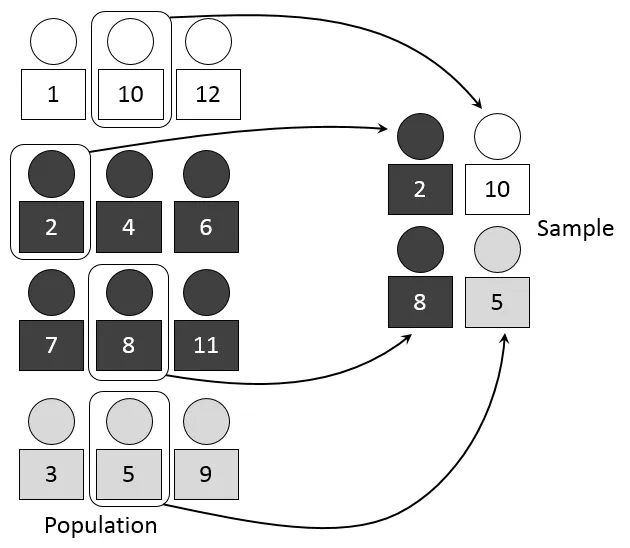

Implementing the concept of stratified sampling in cross-validation ensures the training and test sets have the same proportion of the feature of interest as in the original dataset. Doing this with the target variable ensures that the cross-validation result is a close approximation of generalization error.

#### reference
 - https://towardsdatascience.com/what-is-stratified-cross-validation-in-machine-learning-8844f3e7ae8e
 - https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.datasets import load_boston

In [2]:
APP_PATH = os.getcwd()
DATA_DIR = os.path.join(APP_PATH, 'data')
TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'titanic.train.csv')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'titanic.test.csv')
target_column = "Survived"
stratified_column = "Survived"
stratified_column_index = 1

In [3]:
def read_dataset(path):
    data = pd.read_csv(
        path,
        index_col=None,
        comment='|', 
    )
    #remove eventuais espaços vazios no inicio e/ou fim das colunas do tipo string 'object'
    for i in data.columns:
        if data[i].dtype=='object':
            data[i] = data[i].str.strip()

    #data = data.drop('fnlwgt', axis=1)
    return data

In [4]:
train_data = read_dataset(TRAIN_DATA_FILE)
test_data = read_dataset(TEST_DATA_FILE)

data = pd.concat([train_data, test_data])
data = data.dropna()
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,183.000000,183.000000,183.000000,183,183,183.000000,183.000000,183.000000,183,183.000000,183,183
unique,NaN,NaN,NaN,183,2,NaN,NaN,NaN,127,NaN,133,3
top,NaN,NaN,NaN,"Cumings, Mrs. John Bradley (Florence Briggs Th...",male,NaN,NaN,NaN,113760,NaN,G6,S
freq,NaN,NaN,NaN,1,95,NaN,NaN,NaN,4,NaN,4,116
mean,455.366120,0.672131,1.191257,NaN,NaN,35.674426,0.464481,0.475410,NaN,78.682469,NaN,NaN
std,247.052476,0.470725,0.515187,NaN,NaN,15.643866,0.644159,0.754617,NaN,76.347843,NaN,NaN
min,2.000000,0.000000,1.000000,NaN,NaN,0.920000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,263.500000,0.000000,1.000000,NaN,NaN,24.000000,0.000000,0.000000,NaN,29.700000,NaN,NaN
50%,457.000000,1.000000,1.000000,NaN,NaN,36.000000,0.000000,0.000000,NaN,57.000000,NaN,NaN
75%,676.000000,1.000000,1.000000,NaN,NaN,47.500000,1.000000,1.000000,NaN,90.000000,NaN,NaN


In [5]:
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1.0,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


### hold-out cross-validation without stratified sampling

Hold-out cross validation is implemented using the ‘train_test_split’ method of Scikit-Learn. The implementation is shown below. The method returns training set and test set.

In [6]:
train_df,test_df = train_test_split(data,test_size=0.2,random_state=11)
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{data[stratified_column].value_counts() / len(data)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{train_df[stratified_column].value_counts() / len(train_df)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{test_df[stratified_column].value_counts() / len(test_df)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
1.0    0.664384
0.0    0.335616
Name: Survived, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
1.0    0.702703
0.0    0.297297
Name: Survived, dtype: float64


Since, we haven’t used stratified sampling, we can see that the proportion of the target variable varies hugely among the original dataset, training set and test set

### hold-out cross-validation with stratified sampling

We’ll implement hold-out cross-validation with **stratified sampling** such that the training and the test sets have _same proportion_ of the **target** variable. This can be achieved by setting the ‘stratify’ argument of ‘train_test_split’ to the characteristic of interest (target variable, in this case). It need not necessarily be the target variable, it can even be an input variable which you want to have the same proportion in the training and test sets.

In [7]:
train_df,test_df = train_test_split(data,test_size=0.2,stratify=data[stratified_column],random_state=11)
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{data[stratified_column].value_counts() / len(data)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{train_df[stratified_column].value_counts() / len(train_df)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{test_df[stratified_column].value_counts() / len(test_df)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
1.0    0.671233
0.0    0.328767
Name: Survived, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
1.0    0.675676
0.0    0.324324
Name: Survived, dtype: float64


### k-fold cross-validation without stratified sampling

K-fold cross-validation splits the data into ‘k’ portions. In each of ‘k’ iterations, one portion is used as the test set, while the remaining portions are used for training. Using the ‘KFold’ class of Scikit-Learn, we’ll implement 3-fold cross-validation without stratified sampling.

In [8]:
kfold = KFold(n_splits=3,random_state=11,shuffle=True)
splits = kfold.split(data,data[stratified_column]) # each split has a train indexes and test indexes pair
print(f'PROPORTION OF STRATIFIED COLUMN IN THE ORIGINAL DATA\n{data[stratified_column].value_counts() / len(data)}\n\n')
for n,(train_index,test_index) in enumerate(splits):
    print(f'SPLIT NO {n+1}\nTRAINING SET SIZE: {np.round(len(train_index) / (len(train_index)+len(test_index)),2)}'+
          f'\tTEST SET SIZE: {np.round(len(test_index) / (len(train_index)+len(test_index)),2)}\nPROPORTION OF STRATIFIED COLUMN IN THE TRAINING SET\n'+
          f'{data.iloc[test_index,stratified_column_index].value_counts() / len(data.iloc[test_index,stratified_column_index])}\nPROPORTION OF STRATIFIED COLUMN IN THE TEST SET\n'+
          f'{data.iloc[train_index,stratified_column_index].value_counts() / len(data.iloc[train_index,stratified_column_index])}\n\n')

PROPORTION OF STRATIFIED COLUMN IN THE ORIGINAL DATA
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64


SPLIT NO 1
TRAINING SET SIZE: 0.67	TEST SET SIZE: 0.33
PROPORTION OF STRATIFIED COLUMN IN THE TRAINING SET
1.0    0.688525
0.0    0.311475
Name: Survived, dtype: float64
PROPORTION OF STRATIFIED COLUMN IN THE TEST SET
1.0    0.663934
0.0    0.336066
Name: Survived, dtype: float64


SPLIT NO 2
TRAINING SET SIZE: 0.67	TEST SET SIZE: 0.33
PROPORTION OF STRATIFIED COLUMN IN THE TRAINING SET
1.0    0.639344
0.0    0.360656
Name: Survived, dtype: float64
PROPORTION OF STRATIFIED COLUMN IN THE TEST SET
1.0    0.688525
0.0    0.311475
Name: Survived, dtype: float64


SPLIT NO 3
TRAINING SET SIZE: 0.67	TEST SET SIZE: 0.33
PROPORTION OF STRATIFIED COLUMN IN THE TRAINING SET
1.0    0.688525
0.0    0.311475
Name: Survived, dtype: float64
PROPORTION OF STRATIFIED COLUMN IN THE TEST SET
1.0    0.663934
0.0    0.336066
Name: Survived, dtype: float64




We can see that the proportion of the target variable is **inconsistent** among the original data, training data and test data across splits.

### k-fold cross-validation with stratified sampling

Stratified sampling can be implemented with k-fold cross-validation using the ‘StratifiedKFold’ class of Scikit-Learn. The implementation is shown below.

In [9]:
kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=11)
#data['target'] IS THE VARIABLE USED FOR STRATIFIED SAMPLING.
splits = kfold.split(data,data[stratified_column])
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{data[stratified_column].value_counts() / len(data)}\n\n')
for n,(train_index,test_index) in enumerate(splits):
    print(f'SPLIT NO {n+1}\nTRAINING SET SIZE: {np.round(len(train_index) / (len(train_index)+len(test_index)),2)}'+
          f'\tTEST SET SIZE: {np.round(len(test_index) / (len(train_index)+len(test_index)),2)}\nPROPORTION OF TARGET IN THE TRAINING SET\n'+
          f'{data.iloc[test_index,stratified_column_index].value_counts() / len(data.iloc[test_index,stratified_column_index])}\nPROPORTION OF TARGET IN THE TEST SET\n'+
          f'{data.iloc[train_index,stratified_column_index].value_counts() / len(data.iloc[train_index,stratified_column_index])}\n\n')

PROPORTION OF TARGET IN THE ORIGINAL DATA
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64


SPLIT NO 1
TRAINING SET SIZE: 0.67	TEST SET SIZE: 0.33
PROPORTION OF TARGET IN THE TRAINING SET
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64


SPLIT NO 2
TRAINING SET SIZE: 0.67	TEST SET SIZE: 0.33
PROPORTION OF TARGET IN THE TRAINING SET
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64


SPLIT NO 3
TRAINING SET SIZE: 0.67	TEST SET SIZE: 0.33
PROPORTION OF TARGET IN THE TRAINING SET
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1.0    0.672131
0.0    0.327869
Name: Survived, dtype: float64




In the above results, we can see that the proportion of the target variable is **pretty much consistent** across the original data, training set and test set __in all the three splits__.

Cross-validation implemented using stratified sampling ensures that the proportion of the feature of interest is the same across the original data, training set and the test set. This ensures that no value is over/under-represented in the training and test sets, which gives a more accurate estimate of performance/error.

In [10]:
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets

# FEATCHING FEATURES AND TARGET VARIABLES IN ARRAY FORMAT.
cancer = datasets.load_breast_cancer()
# Input_x_Features.
x = cancer.data						

# Input_ y_Target_Variable.
y = cancer.target					


# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# Create classifier object.
lr = linear_model.LogisticRegression()

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf.split(x, y):
	x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
	y_train_fold, y_test_fold = y[train_index], y[test_index]
	lr.fit(x_train_fold, y_train_fold)
	lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))

# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
	max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
	min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
	mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))


List of possible accuracy: [0.9298245614035088, 0.9649122807017544, 0.9824561403508771, 1.0, 0.9649122807017544, 0.9649122807017544, 0.9824561403508771, 0.9473684210526315, 0.9473684210526315, 0.9821428571428571]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 92.98245614035088 %

Overall Accuracy: 96.66353383458647 %

Standard Deviation is: 0.02097789213195869
